# Projecting COVID-19 Cases With One Step/Multi-Step ARIMA and VAR

### Import Python Modules

In [1]:
from HackathonPackage import CovidModels #Custom module which contains more of our code for the ARIMA models, VAR model, and helper methods
import datetime
import pandas as pd 
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from collections import namedtuple
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

### Read dataset and display fields

In [8]:
df = pd.read_csv("C:\\Users\\dylan.levine\\Development\\Covid Hackathon\\CovidDataset.csv", engine='python', encoding = "utf-8-sig", parse_dates=['date'])
print(df.head())

countryString = 'South Africa'

iso_code continent      country state county  fips       date  total_cases  \
0      AFG      Asia  Afghanistan   N\A    N\A     0 2019-12-31          0.0   
1      AFG      Asia  Afghanistan   N\A    N\A     0 2020-01-01          0.0   
2      AFG      Asia  Afghanistan   N\A    N\A     0 2020-01-02          0.0   
3      AFG      Asia  Afghanistan   N\A    N\A     0 2020-01-03          0.0   
4      AFG      Asia  Afghanistan   N\A    N\A     0 2020-01-04          0.0   

   new_cases  total_deaths  ...  gdp_per_capita  extreme_poverty  \
0        0.0           0.0  ...        1803.987              NaN   
1        0.0           0.0  ...        1803.987              NaN   
2        0.0           0.0  ...        1803.987              NaN   
3        0.0           0.0  ...        1803.987              NaN   
4        0.0           0.0  ...        1803.987              NaN   

   cvd_death_rate diabetes_prevalence  female_smokers  male_smokers  \
0             NaN                9.59    

# Models used in predictions
### (1) Case projection fitted to a log curve
- https://www.who.int/bulletin/online_first/20-257386.pdf "postulating a multi‐parameter logistic trend in the 
cumulative number of COVID‐19 cases that shares similarities across regions agrees well with publicly 
reported data."
- Utilized scipy curve fit to fit a log curve against historical cases, and utilizes projections of the fitted curve as an exogenous regressor in an arima model.

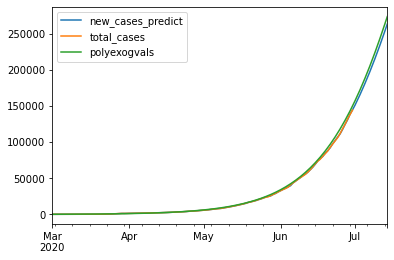

,ARIMALOG predictions
2020-02-07,-110.703430
2020-02-08,78.604335
2020-02-09,3.094808
2020-02-10,2.254733
2020-02-11,1.603991
...,...
2020-07-10,224240.077029
2020-07-11,233641.788969
2020-07-12,243283.993764
2020-07-13,253160.302167


In [9]:
from HackathonPackage import CovidModels #CovidModels objects contains the "backend" code for the models. HackathonPackage module was developed to make backtesting and adhoc analysis easier.

ModelGenerator = CovidModels.HackathonModels(df, countryString) #Initializes a custom hackathon model object based on the raw df dataset and a given region string
stateDF = ModelGenerator.getcountrydf(fields=['date','total_cases']).asfreq('D').fillna(0) #Creates a df for region string
stateDF = stateDF.loc['2020-01-01':'2020-06-30']
exogDF = ModelGenerator.getSigmoidFit(stateDF, "2020-07-14") #Log curve fit to historical cases
statePred = ModelGenerator.run_sarimax_exog(stateDF,exogDF, "2020-07-14")[0] #returns a DF of predicted cases and original total_cases

statePred = statePred.merge(exogDF, how="left", left_index=True, right_index=True) #Merges the log fitted curve to the predictions and actuals

statePred[['new_cases_predict','total_cases', 'polyexogvals']].loc['2020-03-01':'2020-07-14'].plot() #produces the prediction plot through given prediction date
plt.show()

statePred.loc['2020-07-14']

modelComparisons = statePred[['new_cases_predict']] 
modelComparisons = modelComparisons.rename(columns={'new_cases_predict':'ARIMALOG predictions'})
modelComparisons

### (2) Case projection with one step single variable ARIMA, optmizing PDQ paramaters with auto_arima

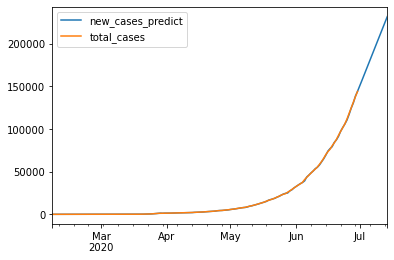

,ARIMALOG predictions,ARIMA predictions
2020-02-07,-110.703430,0.000000
2020-02-08,78.604335,1.666667
2020-02-09,3.094808,1.007501
2020-02-10,2.254733,1.004201
2020-02-11,1.603991,1.000764
...,...,...
2020-07-10,224240.077029,206864.830759
2020-07-11,233641.788969,213127.146612
2020-07-12,243283.993764,219389.462465
2020-07-13,253160.302167,225651.778318


In [10]:
from HackathonPackage import CovidModels #CovidModels objects contains the "backend" code for the models. HackathonPackage module was developed to make backtesting and adhoc analysis easier.

ModelGenerator = CovidModels.HackathonModels(df, countryString) #Initializes a custom hackathon model object based on the raw df dataset and a given region string
stateDF = ModelGenerator.getcountrydf(fields=['date','total_cases']).asfreq('D').fillna(0) #Creates a filtered df for IL
stateDF = stateDF.loc['2020-01-01':'2020-06-30']
statePred = ModelGenerator.run_sarimax(stateDF,"2020-07-14")[0] #returns predictions for the ARIMA model

statePred.loc['2020-01-01':'2020-07-15'].plot()
plt.show()
plt.close()
statePred.loc['2020-07-14']

modelComparisons = modelComparisons.merge(statePred[['new_cases_predict']], how="left", right_index=True, left_index=True)
modelComparisons = modelComparisons.rename(columns={'new_cases_predict':'ARIMA predictions'})
modelComparisons


### (3) VAR model with additonal endogenous stringency index variable, optmizing lag order with statsmodels

total_cases
MovingAvgStringency


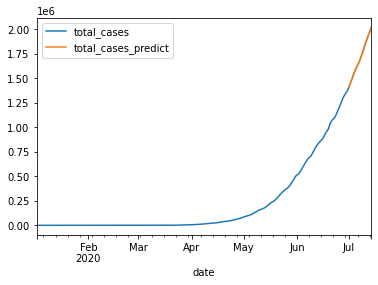

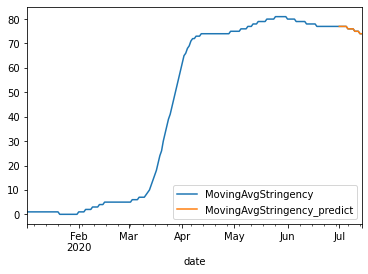

,ARIMALOG predictions,ARIMA predictions,VAR predictions
2020-02-07,-110.703430,0.000000,NaN
2020-02-08,78.604335,1.666667,NaN
2020-02-09,3.094808,1.007501,NaN
2020-02-10,2.254733,1.004201,NaN
2020-02-11,1.603991,1.000764,NaN
...,...,...,...
2020-07-10,224240.077029,206864.830759,1823858.0
2020-07-11,233641.788969,213127.146612,1876441.0
2020-07-12,243283.993764,219389.462465,1925886.0
2020-07-13,253160.302167,225651.778318,1970388.0


In [11]:
from HackathonPackage import CovidModels #CovidModels objects contains the "backend" code for the models. HackathonPackage module was developed to make backtesting and adhoc analysis easier.
ModelGenerator = CovidModels.HackathonModels(df, countryString) #Initializes a custom hackathon model object based on the raw df dataset and a given region string
#ModelGenerator = CovidModels.HackathonModels(df, 'Brazil') #Initializes a custom hackathon model object based on the raw df dataset and a given region string
vardf = ModelGenerator.getcountrydf(fields=['date','total_cases', 'stringency_index']).asfreq('D').fillna(0) #Creates a filtered df for Japan
vardf = vardf.fillna(0).replace(to_replace=0, method='ffill')   #fill zeros and replaces with previous actuals
vardf = vardf.loc['2020-01-01':'2020-06-30']
predictions = ModelGenerator.run_VAR_MAVGStringency_tc(vardf, 13) #returns predictions for the VAR model

predictions[['total_cases', 'total_cases_predict']].plot()
predictions[['MovingAvgStringency', 'MovingAvgStringency_predict']].plot()
plt.show()
plt.close()
predictions.loc['2020-07-14']

modelComparisons = modelComparisons.merge(predictions[['total_cases_predict']], how="left", right_index=True, left_index=True)
modelComparisons = modelComparisons.rename(columns={'total_cases_predict':'VAR predictions'})
modelComparisons


In [12]:
ModelGenerator = CovidModels.HackathonModels(df, countryString) #Initializes a custom hackathon model object based on the raw df dataset and a given region string
stateDF = ModelGenerator.getcountrydf(fields=['date','total_cases']).asfreq('D').fillna(0) #Creates a df for region string
stateDF = stateDF.loc['2020-01-01':'2020-07-14']



modelComparisons = modelComparisons.merge(stateDF[['total_cases']], how="left", right_index=True, left_index=True)
modelComparisons = modelComparisons.rename(columns={'total_cases':'Actual total cases'})
modelComparisons


,ARIMALOG predictions,ARIMA predictions,VAR predictions,Actual total cases
2020-02-07,-110.703430,0.000000,NaN,1.0
2020-02-08,78.604335,1.666667,NaN,1.0
2020-02-09,3.094808,1.007501,NaN,1.0
2020-02-10,2.254733,1.004201,NaN,1.0
2020-02-11,1.603991,1.000764,NaN,1.0
...,...,...,...,...
2020-07-10,224240.077029,206864.830759,1823858.0,238339.0
2020-07-11,233641.788969,213127.146612,1876441.0,250687.0
2020-07-12,243283.993764,219389.462465,1925886.0,264184.0
2020-07-13,253160.302167,225651.778318,1970388.0,276242.0


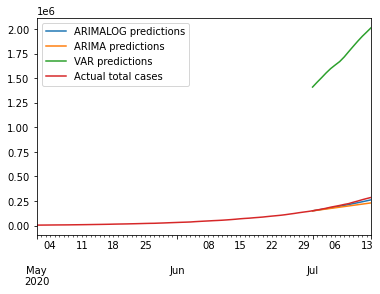

,ARIMALOG predictions,ARIMA predictions,VAR predictions,Actual total cases
2020-02-07,NaN,NaN,NaN,1.0
2020-02-08,NaN,NaN,NaN,1.0
2020-02-09,NaN,NaN,NaN,1.0
2020-02-10,NaN,NaN,NaN,1.0
2020-02-11,NaN,NaN,NaN,1.0
...,...,...,...,...
2020-06-27,NaN,NaN,NaN,124590.0
2020-06-28,NaN,NaN,NaN,131800.0
2020-06-29,NaN,NaN,NaN,138134.0
2020-06-30,NaN,NaN,NaN,144264.0


In [13]:


modelComparisons['ARIMALOG predictions'].loc['2020-01-01':'2020-06-30'] = np.NaN
modelComparisons['ARIMA predictions'].loc['2020-01-01':'2020-06-30'] = np.NaN
modelComparisons['VAR predictions'].loc['2020-01-01':'2020-06-30'] = np.NaN

modelComparisons.loc['2020-05-01':'2020-07-14'].plot()
plt.show()
plt.close()

modelComparisons.loc[:'2020-07-01']


### LSTM model with early stopping and without, refer to Bart's Python file

# Models explored but not used
### Case projections with exogenous variable ARIMA, optmizing PDQ with auto_arima
- Exogenous predictictor is a 4th degree polynomial fitted to the historical case dataset.
- https://www.medrxiv.org/content/10.1101/2020.04.06.20055426v1.full.pdf "The 4th order polynomial refers where disease spread is at its initial stage and expected to grow exponentially; requiring strict policy action to curtail epidemic."
- This model can be effective for states/countries where a "wave" is occurring. Polynomial exogenous predictior approach only utilized where cases are rising as determined by the slope of a fitted line for the last 60 days of cases.

(2, 1, 1)


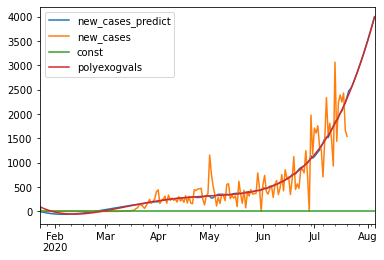

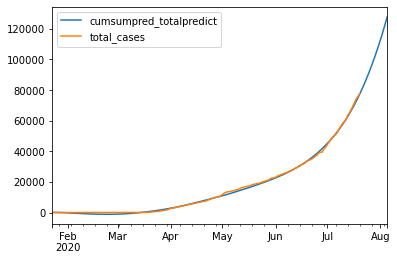

new_cases_predict            4003.333304
new_cases                       0.000000
const                           1.000000
polyexogvals                 3992.534628
cumsumpred_totalpredict    127983.388852
total_cases                          NaN
Name: 2020-08-05 00:00:00, dtype: float64

In [13]:
ModelGenerator = CovidModels.HackathonModels(df, "TN") 
stateDF = ModelGenerator.getstatedf(fields=['date','new_cases']).asfreq('D').fillna(0)
exogDF = ModelGenerator.getPolynomialFit(stateDF, "2020-08-05") 
statePred = ModelGenerator.run_sarimax_exog(stateDF,exogDF, "2020-08-05")[0]
statePred = statePred.merge(exogDF, how="left", right_index=True, left_index=True)
statePred.plot()
stateDF = ModelGenerator.getstatedf(fields=['date','total_cases']).asfreq('D').fillna(0)
#stateDF = stateDF[:"2020-06-30"]
statePred = statePred.fillna(0)
statePred['cumsumpred_totalpredict'] = statePred.new_cases_predict.values.cumsum()

statePred = statePred.merge(stateDF,how="left", right_index=True, left_index=True)
statePred[['cumsumpred_totalpredict', 'total_cases']].plot()
plt.show()
plt.close()
statePred.loc['2020-08-05']


### Fitting cases to an SEIR curve https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7252058/
### Facebook Prophet model

In [4]:
from HackathonPackage import CovidModels
ModelGenerator = CovidModels.HackathonModels(df, "TN") 
stateDF = ModelGenerator.getstatedf(fields=['date','total_cases']).asfreq('D').fillna(0)
statePred = ModelGenerator.linear_predict(stateDF, "2020-08-05")

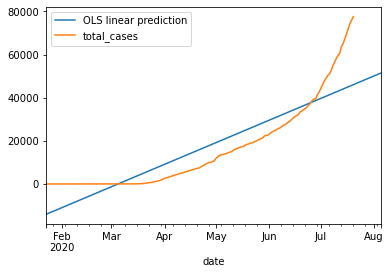

In [8]:
statePred = statePred.merge(stateDF,how="left", right_index=True, left_index=True)
statePred.plot()
plt.show()

In [3]:
statePredDF = pd.DataFrame(statePred)
statePredDF.plot()
plt.show()

NameError: name 'statePred' is not defined

In [20]:
import statsmodels.api as sm
import datetime as dt
stateDF['date'] = stateDF.index

Y = stateDF.total_cases.values
X = stateDF.index.map(dt.datetime.toordinal).values
model = sm.OLS(Y,X) 
results = model.fit()

